In [1]:
import csv
import time
import matplotlib.pyplot as plt
import numpy as np
from casadi import *
from FastDOC import FastDOC
from FastDOC import PDP
import os
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

'1'

In [2]:
def generate_positive_definite_matrix(n, cond_num):
    """Generate a positive definite matrix with a target condition number."""
    Q, _ = np.linalg.qr(np.random.randn(n, n))
    min_eig = 1.0
    max_eig = cond_num
    eigenvalues = np.linspace(min_eig, max_eig, n)
    A = Q @ np.diag(eigenvalues) @ Q.T
    return A

def generate_row_full_rank_matrix(rows, cols):
    """Generate a row-full-rank matrix with the given shape."""
    A = np.random.randn(rows, cols)
    while np.linalg.matrix_rank(A) < rows:
        A = np.random.randn(rows, cols)
    return A

def generate_test_data(N, ns, nc, ntheta, neq=None, cond_number=10):
    """
    Generate random test data for experiments.

    N       : horizon length
    ns      : dimension of state
    nc      : dimension of control
    ntheta  : number of parameters
    neq     : number of constraints (default = ns)
    """
    if neq is None:
        neq = ns

    # Quadratic cost terms
    H_blocks = [generate_positive_definite_matrix(ns + nc, cond_number) for _ in range(N)]
    H = np.array(H_blocks)
    H_T_block = generate_positive_definite_matrix(ns, cond_number)

    # Dynamics constraint matrices
    A_blocks = [generate_row_full_rank_matrix(neq, ns + nc) for _ in range(N)]
    A_blocks = np.array(A_blocks)

    # Parameter-related terms
    B = np.random.randn(N, ns + nc, ntheta)
    B_T_block = np.random.randn(ns, ntheta)
    C = np.random.randn(N + 1, neq, ntheta)
    C[0] = 0.0

    return H, H_T_block, A_blocks, B, B_T_block, C

def recover_auxsys_from_HABC(H_t, H_T, A, B_t, B_T, C):
    """
    input:
      H_t:   (T, ns+nc, ns+nc)
      H_T:   (ns, ns)
      A:     (T, ns, ns+nc)
      B_t:   (T, ns+nc, nz)
      B_T:   (ns, nz)
      C:     (T+1, ns, nz), where C[0] = 0, C[t+1] = -dynE[t]
    output: dictionary for lqr_solver
    """
    T = H_t.shape[0]
    ns = H_T.shape[0]
    nc = H_t.shape[1] - ns
    nz = B_t.shape[2]

    # --- split H blocks ---
    Hxx = H_t[:, :ns, :ns]
    Hxu = H_t[:, :ns, ns:ns+nc]
    Hux = H_t[:, ns:ns+nc, :ns]
    Huu = H_t[:, ns:ns+nc, ns:ns+nc]
    hxx = H_T

    Hxu = 0.5 * (Hxu + np.transpose(Hux, (0,2,1)))
    Hux = np.transpose(Hxu, (0,2,1))

    # --- split A -> dynF, dynG ---
    dynF = -A[:, :, :ns]
    dynG = -A[:, :, ns:ns+nc]

    # --- split B_t -> Hxe, Hue ---
    Hxe = B_t[:, :ns, :]
    Hue = B_t[:, ns:ns+nc, :]
    hxe = B_T

    # --- C -> dynE ---
    assert C.shape[0] == T+1
    dynE = -C[1:]   # shape: (T, ns, nz)

    auxsys = {
        'dynF': dynF,          # list/array of (T, ns, ns)
        'dynG': dynG,          # (T, ns, nc)
        'dynE': dynE,          # (T, ns, nz)
        'Hxx': Hxx,            # (T, ns, ns)
        'Huu': Huu,            # (T, nc, nc)
        'Hxu': Hxu,            # (T, ns, nc)
        'Hux': Hux,            # (T, nc, ns)
        'Hxe': Hxe,            # (T, ns, nz)
        'Hue': Hue,            # (T, nc, nz)
        'hxx': np.array([hxx]),# match your usage: auxsys_OC['hxx'][0]
        'hxe': np.array([hxe]) # idem: auxsys_OC['hxe'][0]
    }
    return auxsys

def _print_progress(done, total, prefix="Progress"):
    """Print a single-line progress bar; keeps overwriting the same line."""
    frac = done / total if total else 1.0
    bar_len = 28
    filled = int(bar_len * frac)
    bar = "#" * filled + "-" * (bar_len - filled)
    percent = int(frac * 100)
    print(f"\r{prefix}: [{bar}] {percent:3d}% ({done}/{total})", end="", flush=True)
    if done == total:
        print()

def run_benchmark(
    vary,                 # 'N' | 'nsnc' | 'ntheta'
    values,
    repeats=20,
    base_N=50,
    base_ns=40,
    base_nc=10,
    base_ntheta=50,
    cond_number=10,
    warmup=True,
    verbose=False,
    compute_diff=False
):
    assert vary in ('N', 'nsnc', 'ntheta'), "vary must be one of 'N', 'nsnc', 'ntheta'"

    # Warmup
    if warmup:
        if vary == 'N':
            N0, ns0, nc0, ntheta0 = values[0], base_ns, base_nc, base_ntheta
        elif vary == 'nsnc':
            ns0 = int(values[0]); nc0 = ns0 // 4
            N0, ntheta0 = base_N, base_ntheta
        else:  # 'ntheta'
            ntheta0 = int(values[0])
            N0, ns0, nc0 = base_N, base_ns, base_nc

        H, H_T_block, A_blocks, B, B_T_block, C = generate_test_data(
            N0, ns0, nc0, ntheta0, cond_number=cond_number
        )
        FastDOC.explicit_solve(H, H_T_block, A_blocks, B, B_T_block, C, ns0, nc0, N0, GN=False)
        FastDOC.explicit_solve(H, H_T_block, A_blocks, B, B_T_block, C, ns0, nc0, N0, GN=True)
        # PDP warmup
        auxsys = recover_auxsys_from_HABC(H, H_T_block, A_blocks, B, B_T_block, C)
        PDPSolver = PDP.LQR()
        PDPSolver.setDyn(dynF=list(auxsys['dynF']), dynG=list(auxsys['dynG']), dynE=list(auxsys['dynE']))
        PDPSolver.setPathCost(Hxx=list(auxsys['Hxx']), Huu=list(auxsys['Huu']),
                              Hxu=list(auxsys['Hxu']), Hux=list(auxsys['Hux']),
                              Hxe=list(auxsys['Hxe']), Hue=list(auxsys['Hue']))
        PDPSolver.setFinalCost(hxx=list(auxsys['hxx']), hxe=list(auxsys['hxe']))
        _ = PDPSolver.lqrSolver(np.zeros((ns0, ntheta0)), N0)

    exact_times_all, approx_times_all, pdp_times_all = [], [], []
    exact_errs_all, pdp_errs_all = [], []
    total_iters = len(values) * repeats
    iter_cnt = 0

    for val in values:
        # Resolve config
        if vary == 'N':
            N, ns, nc, ntheta = int(val), base_ns, base_nc, base_ntheta
            label = f"N={N}"
        elif vary == 'nsnc':
            ns = int(val); nc = ns // 4
            N, ntheta = base_N, base_ntheta
            label = f"ns={ns}, nc={nc}"
        else:  # 'ntheta'
            ntheta = int(val)
            N, ns, nc = base_N, base_ns, base_nc
            label = f"ntheta={ntheta}"

        if verbose:
            print(f"\n==> {vary.upper()} | {label}")

        exact_times, approx_times, pdp_times = [], [], []

        for r in range(repeats):
            iter_cnt += 1
            _print_progress(iter_cnt, total_iters, prefix=f"{vary.upper()} {label}")

            H, H_T_block, A_blocks, B, B_T_block, C = generate_test_data(
                N, ns, nc, ntheta, cond_number=cond_number
            )

            # FastDOC (approx)
            t0 = time.perf_counter()
            sol_approx = FastDOC.explicit_solve(H, H_T_block, A_blocks, B, B_T_block, C, ns, nc, N, GN=True)
            approx_time = time.perf_counter() - t0

            # IDOC (exact)
            t1 = time.perf_counter()
            sol_exact = FastDOC.explicit_solve(H, H_T_block, A_blocks, B, B_T_block, C, ns, nc, N, GN=False)
            exact_time = time.perf_counter() - t1

            # PDP (LQR)
            auxsys = recover_auxsys_from_HABC(H, H_T_block, A_blocks, B, B_T_block, C)
            PDPSolver = PDP.LQR()
            PDPSolver.setDyn(dynF=list(auxsys['dynF']), dynG=list(auxsys['dynG']), dynE=list(auxsys['dynE']))
            PDPSolver.setPathCost(Hxx=list(auxsys['Hxx']), Huu=list(auxsys['Huu']),
                                  Hxu=list(auxsys['Hxu']), Hux=list(auxsys['Hux']),
                                  Hxe=list(auxsys['Hxe']), Hue=list(auxsys['Hue']))
            PDPSolver.setFinalCost(hxx=list(auxsys['hxx']), hxe=list(auxsys['hxe']))
            t2 = time.perf_counter()
            sol_PDP = PDPSolver.lqrSolver(np.zeros((ns, ntheta)), N)
            pdp_time = time.perf_counter() - t2

            def relative_error(a, b):
                a, b = np.array(a), np.array(b)
                return np.linalg.norm(a - b) / (np.linalg.norm(b) + 1e-12)

            err_exact = relative_error(sol_exact['state_traj_opt'], sol_approx['state_traj_opt'])
            err_pdp = relative_error(sol_PDP['state_traj_opt'], sol_approx['state_traj_opt'])

            exact_errs_all.append(err_exact)
            pdp_errs_all.append(err_pdp)

            exact_times.append(exact_time)
            approx_times.append(approx_time)
            pdp_times.append(pdp_time)

        exact_times_all.append(exact_times)
        approx_times_all.append(approx_times)
        pdp_times_all.append(pdp_times)

    exact_mean   = np.array([np.mean(ts) for ts in exact_times_all])
    exact_std    = np.array([np.std(ts, ddof=1) for ts in exact_times_all]) if repeats > 1 else np.zeros_like(exact_mean)
    approx_mean  = np.array([np.mean(ts) for ts in approx_times_all])
    approx_std   = np.array([np.std(ts, ddof=1) for ts in approx_times_all]) if repeats > 1 else np.zeros_like(approx_mean)
    pdp_mean     = np.array([np.mean(ts) for ts in pdp_times_all])
    pdp_std      = np.array([np.std(ts, ddof=1) for ts in pdp_times_all]) if repeats > 1 else np.zeros_like(pdp_mean)
    exact_err_mean = np.array([np.mean(es) for es in exact_errs_all])
    pdp_err_mean = np.array([np.mean(es) for es in pdp_errs_all])

    return {
        'vary': vary,
        'values': list(values),
        'exact_times': exact_times_all,
        'approx_times': approx_times_all,
        'SafePDP_times': pdp_times_all,
        'exact_mean': exact_mean,   'exact_std': exact_std,
        'approx_mean': approx_mean, 'approx_std': approx_std,
        'SafePDP_mean': pdp_mean,       'SafePDP_std': pdp_std,
        'base_N': base_N, 'base_ns': base_ns, 'base_nc': base_nc, 'base_ntheta': base_ntheta,
        'IDOC_relerr_mean': exact_err_mean,
        'SafePDP_relerr_mean': pdp_err_mean,
    }

def save_results(res, prefix="results"):
    output_dir = "numerical_result"
    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.join(output_dir, f"{prefix}.csv")
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "value", "N", "ns", "nc", "ntheta",
            "IDOC_mean", "IDOC_std",
            "FastDOC_mean", "FastDOC_std",
            "SafePDP_mean", "SafePDP_std",
            "IDOC_relerr_mean", "SafePDP_relerr_mean"  # 只保留均值
        ])
        for i, val in enumerate(res["values"]):
            N = res.get("base_N", 50)
            ns = res.get("base_ns", 40)
            nc = res.get("base_nc", 10)
            ntheta = res.get("base_ntheta", 50)
            if res["vary"] == "N":
                N = val
            elif res["vary"] == "nsnc":
                ns = val; nc = ns // 4
            elif res["vary"] == "ntheta":
                ntheta = val
            writer.writerow([
                val, N, ns, nc, ntheta,
                float(res["exact_mean"][i]),  float(res["exact_std"][i]),
                float(res["approx_mean"][i]), float(res["approx_std"][i]),
                float(res["SafePDP_mean"][i]), float(res["SafePDP_std"][i]),
                float(res["IDOC_relerr_mean"][i]), float(res["SafePDP_relerr_mean"][i])
            ])
    print(f"Saved summary CSV to {filename}")

def plot_time_logy(res, title, xlabel, savepath=None):
    x = np.array(res['values'])
    ex_mu = res['exact_mean']
    ap_mu = res['approx_mean']
    pd_mu = res['SafePDP_mean']

    plt.figure(figsize=(6.6, 4.2))
    plt.plot(x, ap_mu, marker='s', linestyle='-', label='FastDOC')
    plt.plot(x, ex_mu, marker='o', linestyle='-', label='IDOC')
    plt.plot(x, pd_mu, marker='^', linestyle='-', label='SafePDP')

    plt.yscale('log')
    plt.xlabel(xlabel)
    plt.ylabel('Computation Time (s)')
    plt.title(title)
    plt.grid(True, which='both', linestyle='--', alpha=0.4)
    plt.legend()

    if savepath:
        output_dir = "numerical_result"
        os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
        savepath = os.path.join(output_dir, savepath)
        plt.savefig(savepath, bbox_inches='tight', dpi=150)
    plt.show()

In [3]:
np.random.seed(42)

base_N, base_ns, base_nc, base_ntheta = 50, 40, 10, 50
cond_number = 1000
repeats = 20

N_values      = [10, 50, 100, 200, 400, 600, 800, 1000]
ns_values     = [4,  20,  40,  80, 120, 160, 200]
ntheta_values = [20, 80 ,200, 400 ,800, 1200,1600,2000]

N N=1000: [############################] 100% (160/160)
Saved summary CSV to numerical_result\bench_time_vs_N.csv


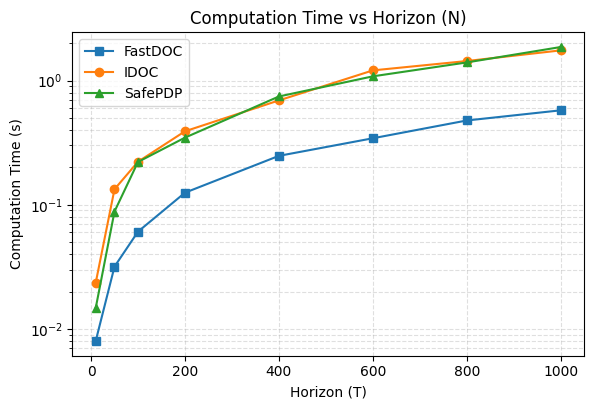

In [4]:
# 1) vary N
res_N = run_benchmark(
    vary='N',
    values=N_values,
    repeats=repeats,
    base_N=base_N, base_ns=base_ns, base_nc=base_nc, base_ntheta=base_ntheta,
    cond_number=cond_number,
    warmup=True, verbose=False, compute_diff=False
)
save_results(res_N, prefix="bench_time_vs_N")
plot_time_logy(res_N, title="Computation Time vs Horizon (N)", xlabel="Horizon (T)",
               savepath="bench_time_vs_N.png")

NSNC ns=200, nc=50: [############################] 100% (140/140)
Saved summary CSV to numerical_result\bench_time_vs_ns.csv


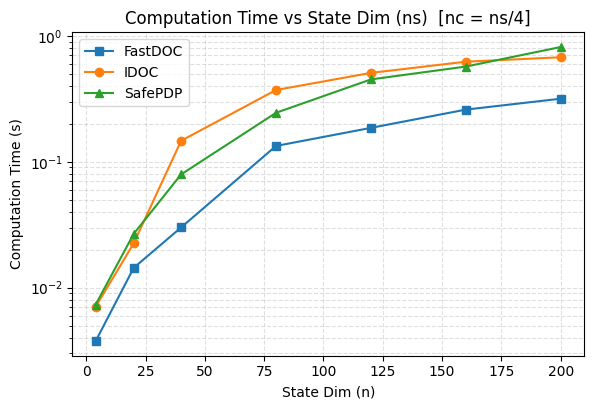

In [5]:
# 2) vary ns & nc (keep 4:1)
res_ns = run_benchmark(
    vary='nsnc',
    values=ns_values,
    repeats=repeats,
    base_N=base_N, base_ns=base_ns, base_nc=base_nc, base_ntheta=base_ntheta,
    cond_number=cond_number,
    warmup=True, verbose=False, compute_diff=False
)
save_results(res_ns, prefix="bench_time_vs_ns")
plot_time_logy(res_ns, title="Computation Time vs State Dim (ns)  [nc = ns/4]", xlabel="State Dim (n)",
               savepath="bench_time_vs_ns.png")

NTHETA ntheta=2000: [############################] 100% (160/160)
Saved summary CSV to numerical_result\bench_time_vs_ntheta.csv


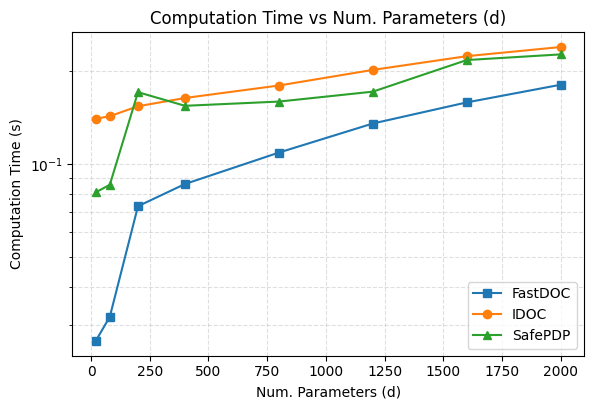

In [6]:
# 3) vary ntheta
res_ntheta = run_benchmark(
    vary='ntheta',
    values=ntheta_values,
    repeats=repeats,
    base_N=base_N, base_ns=base_ns, base_nc=base_nc, base_ntheta=base_ntheta,
    cond_number=cond_number,
    warmup=True, verbose=False, compute_diff=False
)
save_results(res_ntheta, prefix="bench_time_vs_ntheta")
plot_time_logy(res_ntheta, title="Computation Time vs Num. Parameters (d)", xlabel="Num. Parameters (d)",
               savepath="bench_time_vs_ntheta.png")

In [8]:
import pandas as pd
import os
import numpy as np

# List of benchmark result files (for three experiments)
files = [
    "numerical_result/bench_time_vs_N.csv",
    "numerical_result/bench_time_vs_ns.csv",
    "numerical_result/bench_time_vs_ntheta.csv"
]

print("==== FastDOC Speedup Summary (vs IDOC and SafePDP) ====\n")

all_speedups_idoc = []
all_speedups_safepdp = []

for fpath in files:
    if not os.path.exists(fpath):
        print(f"⚠️ File not found: {fpath}")
        continue

    # === Read benchmark data ===
    df = pd.read_csv(fpath)

    # Convert any CasADi DM or object-like entries to float
    df = df.applymap(lambda x: float(x) if hasattr(x, "__float__") else x)

    # === Compute speedups ===
    df["Speedup_vs_IDOC"] = df["IDOC_mean"] / df["FastDOC_mean"]
    df["Speedup_vs_SafePDP"] = df["SafePDP_mean"] / df["FastDOC_mean"]

    # Convert to NumPy float arrays to avoid DM issues
    s_idoc = np.asarray(df["Speedup_vs_IDOC"], dtype=float)
    s_safe = np.asarray(df["Speedup_vs_SafePDP"], dtype=float)

    # === Compute averages for this experiment ===
    avg_vs_idoc = np.mean(s_idoc)
    avg_vs_safepdp = np.mean(s_safe)
    avg_err_idoc = np.mean(np.asarray(df["IDOC_relerr_mean"], dtype=float))
    avg_err_safepdp = np.mean(np.asarray(df["SafePDP_relerr_mean"], dtype=float))

    # Append all values for overall averaging
    all_speedups_idoc.extend(s_idoc)
    all_speedups_safepdp.extend(s_safe)

    exp_name = os.path.basename(fpath).replace("bench_time_vs_", "").replace(".csv", "")
    print(f"  Experiment: {exp_name}")
    print(f"    FastDOC vs IDOC:     {avg_vs_idoc:.2f}x faster")
    print(f"    FastDOC vs SafePDP:  {avg_vs_safepdp:.2f}x faster")
    print(f"    Mean relative errors → IDOC={avg_err_idoc:.2e}, SafePDP={avg_err_safepdp:.2e}\n")

# === Compute overall average speedups ===
overall_idoc = np.mean(all_speedups_idoc)
overall_safepdp = np.mean(all_speedups_safepdp)

print("==== Overall Average Speedup ====")
print(f"  FastDOC vs IDOC:     {overall_idoc:.2f}x faster (overall)")
print(f"  FastDOC vs SafePDP:  {overall_safepdp:.2f}x faster (overall)")


==== FastDOC Speedup Summary (vs IDOC and SafePDP) ====

  Experiment: N
    FastDOC vs IDOC:     3.28x faster
    FastDOC vs SafePDP:  2.92x faster
    Mean relative errors → IDOC=2.11e-08, SafePDP=4.54e-06

  Experiment: ns
    FastDOC vs IDOC:     2.62x faster
    FastDOC vs SafePDP:  2.21x faster
    Mean relative errors → IDOC=1.79e-12, SafePDP=3.16e-12

  Experiment: ntheta
    FastDOC vs IDOC:     2.46x faster
    FastDOC vs SafePDP:  1.90x faster
    Mean relative errors → IDOC=2.28e-08, SafePDP=3.58e-06

==== Overall Average Speedup ====
  FastDOC vs IDOC:     2.80x faster (overall)
  FastDOC vs SafePDP:  2.35x faster (overall)
